In [ ]:
!git clone https://github.com/horacemtb/Anime-recommender-engine.git

Cloning into 'Anime-recommender-engine'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 128 (delta 38), reused 75 (delta 17), pack-reused 21 (from 1)
Receiving objects: 100% (128/128), 75.11 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (41/41), done.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import random
import pickle
from tqdm import tqdm
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from training_utils import EarlyStopping, train_one_epoch, evaluate
from utils import (filter_data_by_users,
                   ensure_full_coverage,
                   calculate_mbp_label_distribution,
                   calculate_nbp_label_distribution,
                   calculate_accuracy,
                   plot_loss,
                   infer_single_user,
                   generate_user_embedding,
                   save_user_embeddings_to_dataframe,
                   evaluate_with_clustering,
                   calculate_clustering_metrics
                   )
from datasets import PTUMMBPDataset, PTUMNBPDataset, mbp_collate_fn, nbp_collate_fn
from model import PTUMTransformerModel

In [ ]:
ratings = pd.read_csv('/content/Anime-recommender-engine/app/data/rating_selected.csv')

In [ ]:
ratings

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
...,...,...,...
2435908,15000,39587,8
2435909,15000,31240,9
2435910,15000,27775,7
2435911,15000,11757,7


In [ ]:
ratings['user_id'].nunique()

13102

In [ ]:
ratings['anime_id'].nunique()

14353

We will start by sorting the anime and users based on their frequency of occurrence. Extremely rare shows and inactive users will be excluded, as well as super-users — those who have watched more than 1,000 anime titles.

In [ ]:
USER_MIN_COUNT = 5
ANIME_MIN_COUNT = 5
MAX_USER_INTERACTIONS = 1000

# Filter popular animes
anime_counts = ratings.groupby('anime_id').size()
popular_animes = anime_counts[anime_counts >= ANIME_MIN_COUNT].index
filtered_ratings = ratings[ratings['anime_id'].isin(popular_animes)]

# Filter active users
user_counts = filtered_ratings.groupby('user_id').size()
active_users = user_counts[
    (user_counts >= USER_MIN_COUNT) & (user_counts <= MAX_USER_INTERACTIONS)
].index
filtered_ratings = filtered_ratings[filtered_ratings['user_id'].isin(active_users)]

filtered_ratings.reset_index(inplace = True, drop = True)

In [ ]:
filtered_ratings['anime_id'].nunique()

10296

In [ ]:
filtered_ratings['user_id'].nunique()

12188

In [ ]:
filtered_ratings.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [ ]:
# Get unique anime_ids and create a mapping for the embedding layer
unique_anime_ids = filtered_ratings['anime_id'].unique()
anime_id_to_index = {anime_id: idx + 1 for idx, anime_id in enumerate(unique_anime_ids)}  # Start from 1 (since 0 is reserved for padding)

# Map anime_ids in the dataset to numerical indices
filtered_ratings['anime_id'] = filtered_ratings['anime_id'].map(anime_id_to_index)

In [ ]:
with open('anime_id_to_index.pkl', 'wb') as f:
    pickle.dump(anime_id_to_index, f)

In [ ]:
min(filtered_ratings['anime_id'])

1

In [ ]:
max(filtered_ratings['anime_id'])

10296

# Step 1: Data Preparation

We will split the data into three groups: train and validation sets for training the PTUM model, and a holdout set reserved for further development or evaluation.

In [ ]:
# Group user behaviors
user_behaviors = filtered_ratings.groupby('user_id')['anime_id'].apply(list).to_dict()

# Split Group A (80% for pre-training)
all_users = list(user_behaviors.keys())
pretrain_users, holdout_users = train_test_split(all_users, test_size = 0.2, random_state = 89)

# Split Group A into train and evaluation sets (80-20 split)
pretrain_train_users, pretrain_eval_users = train_test_split(pretrain_users, test_size = 0.2, random_state = 77)

pretrain_train_data = filter_data_by_users(filtered_ratings, pretrain_train_users)
pretrain_eval_data = filter_data_by_users(filtered_ratings, pretrain_eval_users)
holdout_data = filter_data_by_users(filtered_ratings, holdout_users)

In [ ]:
# Ensure full anime coverage in train dataset
pretrain_train_data, pretrain_eval_data = ensure_full_coverage(pretrain_eval_data, pretrain_train_data)
pretrain_train_data, holdout_data = ensure_full_coverage(holdout_data, pretrain_train_data)

print("Unique anime IDs in pretrain_train_data:", len(pretrain_train_data['anime_id'].unique()))
print("Unique anime IDs in pretrain_eval_data:", len(pretrain_eval_data['anime_id'].unique()))
print("Unique anime IDs in holdout_data:", len(holdout_data['anime_id'].unique()))

print("Unique user IDs in pretrain_train_data:", len(pretrain_train_data['user_id'].unique()))
print("Unique user IDs in pretrain_eval_data:", len(pretrain_eval_data['user_id'].unique()))
print("Unique user IDs in holdout_data:", len(holdout_data['user_id'].unique()))

Missing anime IDs in target set: {8706, 9737, 9738, 10254, 10256, 10257, 10258, 10259, 8212, 10260, 10261, 10267, 10268, 10276, 10277, 10278, 10279, 9768, 3630, 9777, 10292, 10293, 10294, 3642, 9791, 8772, 8773, 8779, 8780, 8782, 8785, 7764, 3669, 7765, 8793, 3676, 7773, 9821, 3682, 9314, 9827, 3713, 3714, 3716, 3720, 3723, 3724, 7820, 9355, 9356, 9357, 9874, 9363, 9875, 9366, 7834, 3745, 7841, 8868, 7845, 9895, 8873, 7851, 7856, 7857, 9906, 9907, 9908, 9909, 9400, 9405, 9412, 9939, 6878, 9968, 9970, 8466, 8469, 10008, 3364, 8494, 6451, 10044, 9031, 10055, 9034, 9047, 10084, 8040, 10089, 10104, 10110, 10111, 10121, 9619, 7065, 9656, 6585, 6586, 9658, 3517, 10174, 9666, 9159, 9677, 10197, 10198, 10199, 10204, 10205, 10206, 10208, 10213, 6630, 9705, 9706, 9707, 9708, 9709, 10218, 9712, 9713, 10225, 9715, 10233, 9722, 9723, 10237}
Missing anime IDs in target set: {9985, 9858, 8963, 9986, 7813, 9987, 10113, 10116, 10119, 10120, 10122, 10123, 7821, 7054, 10125, 7056, 10004, 7831, 10007, 102

In [ ]:
# holdout_data.to_csv('holdout_data.csv', index = False)

# Step 2: Construct Datasets and DataLoaders

Two separate datasets and dataloaders will be created to support two distinct tasks:

1. Masked behavior prediction
2. Next K behavior prediction

In [ ]:
P = 4  # Number of negative samples
K = 2 # Number of future behaviors to predict
max_seq_len = MAX_USER_INTERACTIONS
num_animes = max(pretrain_train_data['anime_id'].unique())
batch_size = 16

pretrain_train_users = pretrain_train_data['user_id'].unique()
pretrain_eval_users = pretrain_eval_data['user_id'].unique()

mpb_train_dataset = PTUMMBPDataset(pretrain_train_users, user_behaviors, num_animes, P)
mpb_eval_dataset = PTUMMBPDataset(pretrain_eval_users, user_behaviors, num_animes, P)

npb_train_dataset = PTUMNBPDataset(pretrain_train_users, user_behaviors, num_animes, P, K)
npb_eval_dataset = PTUMNBPDataset(pretrain_eval_users, user_behaviors, num_animes, P, K)

mbp_train_loader = DataLoader(mpb_train_dataset, batch_size = batch_size, shuffle = True,
                          collate_fn = lambda batch: mbp_collate_fn(batch, max_seq_len))
mbp_eval_loader = DataLoader(mpb_eval_dataset, batch_size = batch_size, shuffle = False,
                         collate_fn = lambda batch: mbp_collate_fn(batch, max_seq_len))

nbp_train_loader = DataLoader(npb_train_dataset, batch_size = batch_size, shuffle = True,
                          collate_fn = lambda batch: nbp_collate_fn(batch, max_seq_len))
nbp_eval_loader = DataLoader(npb_eval_dataset, batch_size = batch_size, shuffle = False,
                         collate_fn = lambda batch: nbp_collate_fn(batch, max_seq_len))

In [ ]:
it = iter(mbp_train_loader)
first = next(it)

In [ ]:
first

(tensor([[1003,  417,  415,  ...,    0,    0,    0],
         [  19,  454, 2037,  ...,    0,    0,    0],
         [ 228,  168,  169,  ...,    0,    0,    0],
         ...,
         [1797, 1794,  387,  ...,    0,    0,    0],
         [2009, 1005, 5710,  ...,    0,    0,    0],
         [  37,   36,  380,  ...,    0,    0,    0]]),
 tensor([[  376,   326,   389,  7929,  2197],
         [ 2789,   119,  1641,  1509,  5058],
         [   14,  2760,   130,  5240,  9683],
         [ 3380,   624,  2284,  8111,  2461],
         [ 1206,  6490,  1523,  9177,  3848],
         [ 6555,  6624,  8691,   476,  6036],
         [ 8824,  1181,  2911,  9849,   872],
         [ 1426,  8030,   842,  4767,  3241],
         [  895,  6172,   176,  1925,  9860],
         [ 9056,   149,  5636,  9643,  4400],
         [  569,  8982,   811, 10078,  6046],
         [ 3364,  1503,  7572,  6473,   527],
         [ 6845,    81,  2905,  7775,  5392],
         [ 2629,  6614,  7515,   177,  1167],
         [ 7733,  4436

In [ ]:
it = iter(nbp_train_loader)
first = next(it)

In [ ]:
first

(tensor([[ 321,   80,  798,  ...,    0,    0,    0],
         [2030, 3348, 3781,  ...,    0,    0,    0],
         [1297, 1771,  108,  ...,    0,    0,    0],
         ...,
         [ 223,  222, 1492,  ...,    0,    0,    0],
         [ 478,  647, 1248,  ...,    0,    0,    0],
         [1014,  124,  113,  ...,    0,    0,    0]]),
 tensor([[[ 4462,   151,  9264,  4415,  9943],
          [ 1101,  5362,  6432,   213,  5664]],
 
         [[ 6767,  6774,  2642,  4636,   124],
          [ 9806,  2045,   131,  9385,  5591]],
 
         [[ 9507,  4570,  3989,  1120,  9684],
          [ 7578,  1311,   495,   988,  6562]],
 
         [[ 5535,  2644,  6886,   289,  9459],
          [ 3219,  2592,  6019,  1363,  1449]],
 
         [[ 5424,  7160,  1440,  6565,  9062],
          [ 2807,  8769,   421,  4480,  5209]],
 
         [[  660,  2354,  9572,  8317,  9222],
          [  379,    64,  5478,  2037,  8570]],
 
         [[ 4975,  6801,  1862,  8252,  8531],
          [10001,  7536,  5641,  5299

# Step 3: Load Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
embed_dim = 128
num_heads = 4
hidden_dim = 512
num_layers = 2
dropout = 0.1

model = PTUMTransformerModel(num_animes, embed_dim, num_heads, hidden_dim, num_layers, dropout)

# Step 4: Training and Evaluation

Count the label distribution to ensure the dataset is balanced, allowing us to safely use accuracy as a metric for quality estimation.

In [ ]:
label_distribution = calculate_mbp_label_distribution(mbp_train_loader, P+1)
print(f"Label distribution in training set: {label_distribution}")

Label distribution in training set: {0: 0.20763512662214942, 1: 0.18835832178404938, 2: 0.20209147032883962, 3: 0.19818571248582587, 4: 0.2037293687791357}


In [ ]:
label_distribution = calculate_nbp_label_distribution(nbp_train_loader, P+1, K)
print(f"Label distribution in training set: {label_distribution}")

Label distribution in training set: {0: 0.2048632984754945, 1: 0.20599722817185334, 2: 0.19837470076855235, 3: 0.189807231951619, 4: 0.20095754063248078}


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

model = model.to(device)

early_stopping = EarlyStopping(patience=5, delta=0.005, save_path='ptum-best-params.pt')

In [ ]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

num_epochs = 50
for epoch in range(num_epochs):

    train_loss, mbp_train_accuracy, nbp_train_accuracy = train_one_epoch(model, mbp_train_loader, nbp_train_loader, optimizer, device)
    eval_loss, mbp_eval_accuracy, nbp_eval_accuracy = evaluate(model, mbp_eval_loader, nbp_eval_loader, device)

    train_losses.append(train_loss)
    valid_losses.append(eval_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, MBP Train Accuracy: {mbp_train_accuracy:.4f}, NBP Train Accuracy: {nbp_train_accuracy:.4f}")
    print(f"Eval Loss: {eval_loss:.4f}, MBP Eval Accuracy: {mbp_eval_accuracy:.4f}, NBP Eval Accuracy: {nbp_eval_accuracy:.4f}")

    early_stopping(eval_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Training: 497it [01:11,  6.97it/s]
Evaluating: 0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Evaluating: 118it [00:01, 76.72it/s]


Epoch 1/50
Train Loss: 5.8100, MBP Train Accuracy: 0.2482, NBP Train Accuracy: 0.2465
Eval Loss: 4.3472, MBP Eval Accuracy: 0.2714, NBP Eval Accuracy: 0.2758
Best model saved at ptum-best-params.pt


Training: 497it [01:09,  7.19it/s]
Evaluating: 118it [00:01, 81.88it/s]


Epoch 2/50
Train Loss: 3.8216, MBP Train Accuracy: 0.3216, NBP Train Accuracy: 0.3252
Eval Loss: 3.3270, MBP Eval Accuracy: 0.3758, NBP Eval Accuracy: 0.3815
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.21it/s]
Evaluating: 118it [00:01, 82.39it/s]


Epoch 3/50
Train Loss: 2.9630, MBP Train Accuracy: 0.4549, NBP Train Accuracy: 0.4550
Eval Loss: 2.6204, MBP Eval Accuracy: 0.5112, NBP Eval Accuracy: 0.5101
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.23it/s]
Evaluating: 118it [00:01, 81.43it/s]


Epoch 4/50
Train Loss: 2.2828, MBP Train Accuracy: 0.5832, NBP Train Accuracy: 0.5821
Eval Loss: 2.0212, MBP Eval Accuracy: 0.6331, NBP Eval Accuracy: 0.6265
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 81.88it/s]


Epoch 5/50
Train Loss: 1.8504, MBP Train Accuracy: 0.6662, NBP Train Accuracy: 0.6704
Eval Loss: 1.7308, MBP Eval Accuracy: 0.6916, NBP Eval Accuracy: 0.6875
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.25it/s]
Evaluating: 118it [00:01, 79.94it/s]


Epoch 6/50
Train Loss: 1.5710, MBP Train Accuracy: 0.7069, NBP Train Accuracy: 0.7269
Eval Loss: 1.4808, MBP Eval Accuracy: 0.7403, NBP Eval Accuracy: 0.7370
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 80.27it/s]


Epoch 7/50
Train Loss: 1.3832, MBP Train Accuracy: 0.7461, NBP Train Accuracy: 0.7527
Eval Loss: 1.3922, MBP Eval Accuracy: 0.7589, NBP Eval Accuracy: 0.7502
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 81.86it/s]


Epoch 8/50
Train Loss: 1.3227, MBP Train Accuracy: 0.7496, NBP Train Accuracy: 0.7617
Eval Loss: 1.3048, MBP Eval Accuracy: 0.7757, NBP Eval Accuracy: 0.7588
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 82.38it/s]


Epoch 9/50
Train Loss: 1.2438, MBP Train Accuracy: 0.7633, NBP Train Accuracy: 0.7763
Eval Loss: 1.2916, MBP Eval Accuracy: 0.7762, NBP Eval Accuracy: 0.7576
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.24it/s]
Evaluating: 118it [00:01, 78.16it/s]


Epoch 10/50
Train Loss: 1.2035, MBP Train Accuracy: 0.7669, NBP Train Accuracy: 0.7821
Eval Loss: 1.2583, MBP Eval Accuracy: 0.7707, NBP Eval Accuracy: 0.7729
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.21it/s]
Evaluating: 118it [00:01, 79.52it/s]


Epoch 11/50
Train Loss: 1.1896, MBP Train Accuracy: 0.7655, NBP Train Accuracy: 0.7829
Eval Loss: 1.2672, MBP Eval Accuracy: 0.7705, NBP Eval Accuracy: 0.7669


Training: 497it [01:08,  7.24it/s]
Evaluating: 118it [00:01, 72.73it/s]


Epoch 12/50
Train Loss: 1.1552, MBP Train Accuracy: 0.7690, NBP Train Accuracy: 0.7907
Eval Loss: 1.2671, MBP Eval Accuracy: 0.7570, NBP Eval Accuracy: 0.7738


Training: 497it [01:08,  7.24it/s]
Evaluating: 118it [00:01, 78.94it/s]


Epoch 13/50
Train Loss: 1.1629, MBP Train Accuracy: 0.7657, NBP Train Accuracy: 0.7956
Eval Loss: 1.2180, MBP Eval Accuracy: 0.7791, NBP Eval Accuracy: 0.7751
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.25it/s]
Evaluating: 118it [00:01, 78.64it/s]


Epoch 14/50
Train Loss: 1.1505, MBP Train Accuracy: 0.7658, NBP Train Accuracy: 0.7918
Eval Loss: 1.2007, MBP Eval Accuracy: 0.7691, NBP Eval Accuracy: 0.7804
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.24it/s]
Evaluating: 118it [00:01, 82.12it/s]


Epoch 15/50
Train Loss: 1.1463, MBP Train Accuracy: 0.7715, NBP Train Accuracy: 0.7923
Eval Loss: 1.2161, MBP Eval Accuracy: 0.7767, NBP Eval Accuracy: 0.7725


Training: 497it [01:08,  7.23it/s]
Evaluating: 118it [00:02, 54.41it/s]


Epoch 16/50
Train Loss: 1.1684, MBP Train Accuracy: 0.7599, NBP Train Accuracy: 0.7928
Eval Loss: 1.2129, MBP Eval Accuracy: 0.7822, NBP Eval Accuracy: 0.7777


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 81.29it/s]


Epoch 17/50
Train Loss: 1.1341, MBP Train Accuracy: 0.7681, NBP Train Accuracy: 0.7985
Eval Loss: 1.2087, MBP Eval Accuracy: 0.7811, NBP Eval Accuracy: 0.7745


Training: 497it [01:08,  7.23it/s]
Evaluating: 118it [00:02, 52.64it/s]


Epoch 18/50
Train Loss: 1.1361, MBP Train Accuracy: 0.7758, NBP Train Accuracy: 0.7945
Eval Loss: 1.1851, MBP Eval Accuracy: 0.7894, NBP Eval Accuracy: 0.7736
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 80.60it/s]


Epoch 19/50
Train Loss: 1.1440, MBP Train Accuracy: 0.7720, NBP Train Accuracy: 0.7943
Eval Loss: 1.1840, MBP Eval Accuracy: 0.7894, NBP Eval Accuracy: 0.7718


Training: 497it [01:08,  7.21it/s]
Evaluating: 118it [00:01, 60.55it/s]


Epoch 20/50
Train Loss: 1.1134, MBP Train Accuracy: 0.7704, NBP Train Accuracy: 0.7977
Eval Loss: 1.1962, MBP Eval Accuracy: 0.7859, NBP Eval Accuracy: 0.7829


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 80.10it/s]


Epoch 21/50
Train Loss: 1.1117, MBP Train Accuracy: 0.7763, NBP Train Accuracy: 0.7992
Eval Loss: 1.2009, MBP Eval Accuracy: 0.7843, NBP Eval Accuracy: 0.7759


Training: 497it [01:08,  7.21it/s]
Evaluating: 118it [00:01, 74.29it/s]


Epoch 22/50
Train Loss: 1.1193, MBP Train Accuracy: 0.7723, NBP Train Accuracy: 0.7984
Eval Loss: 1.1664, MBP Eval Accuracy: 0.7880, NBP Eval Accuracy: 0.7871
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 82.51it/s]


Epoch 23/50
Train Loss: 1.1106, MBP Train Accuracy: 0.7724, NBP Train Accuracy: 0.7994
Eval Loss: 1.1558, MBP Eval Accuracy: 0.7949, NBP Eval Accuracy: 0.7809
Best model saved at ptum-best-params.pt


Training: 497it [01:08,  7.21it/s]
Evaluating: 118it [00:01, 80.89it/s]


Epoch 24/50
Train Loss: 1.1268, MBP Train Accuracy: 0.7666, NBP Train Accuracy: 0.7975
Eval Loss: 1.2123, MBP Eval Accuracy: 0.7873, NBP Eval Accuracy: 0.7724


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 81.56it/s]


Epoch 25/50
Train Loss: 1.1070, MBP Train Accuracy: 0.7734, NBP Train Accuracy: 0.7991
Eval Loss: 1.1774, MBP Eval Accuracy: 0.7816, NBP Eval Accuracy: 0.7841


Training: 497it [01:08,  7.22it/s]
Evaluating: 118it [00:01, 72.37it/s]


Epoch 26/50
Train Loss: 1.1213, MBP Train Accuracy: 0.7757, NBP Train Accuracy: 0.7993
Eval Loss: 1.1845, MBP Eval Accuracy: 0.7760, NBP Eval Accuracy: 0.7802


Training: 497it [01:10,  7.10it/s]
Evaluating: 118it [00:01, 81.84it/s]


Epoch 27/50
Train Loss: 1.1144, MBP Train Accuracy: 0.7746, NBP Train Accuracy: 0.7990
Eval Loss: 1.2182, MBP Eval Accuracy: 0.7760, NBP Eval Accuracy: 0.7795


Training: 497it [01:08,  7.21it/s]
Evaluating: 118it [00:01, 80.00it/s]

Epoch 28/50
Train Loss: 1.1132, MBP Train Accuracy: 0.7697, NBP Train Accuracy: 0.8002
Eval Loss: 1.2135, MBP Eval Accuracy: 0.7754, NBP Eval Accuracy: 0.7713
Early stopping


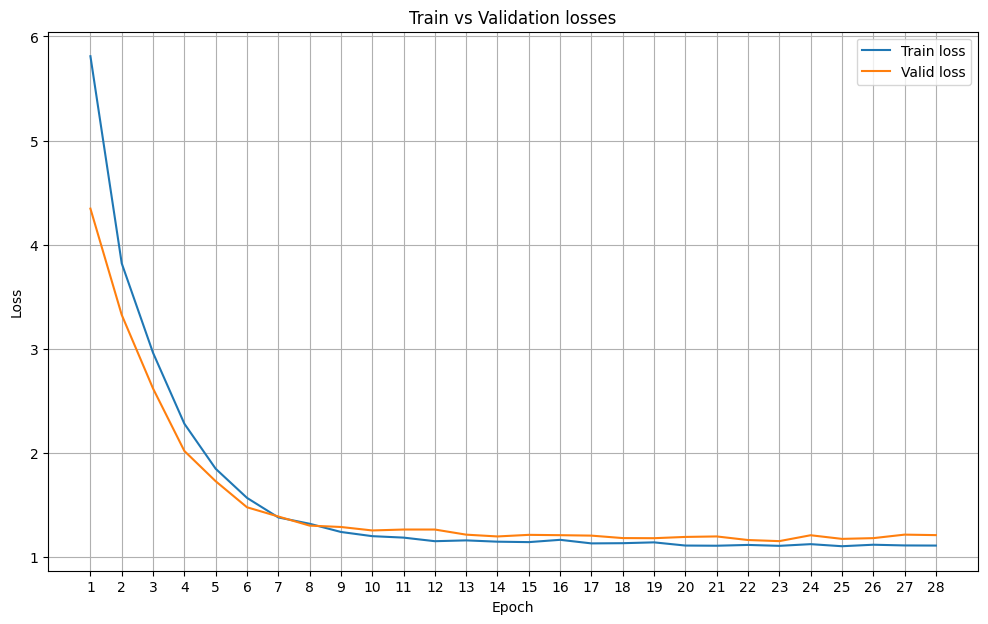

In [ ]:
plot_loss(train_losses, valid_losses)

In [ ]:
early_stopping.load_best_model(model)
# model.load_state_dict(torch.load('/content/ptum-weights-best.pt'))

Best model loaded from ptum-best-params.pt


/content/training_utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.save_path))


In [ ]:
model.to(device)

PTUMTransformerModel(
  (anime_embedding): Embedding(10297, 128)
  (user_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [ ]:
eval_loss, eval_mbp_eval_accuracy, eval_nbp_eval_accuracy = evaluate(model, mbp_eval_loader, nbp_eval_loader, device)

Evaluating: 118it [00:02, 43.01it/s]


In [ ]:
print(f"Eval Loss: {eval_loss:.4f}, MBP Eval Accuracy: {eval_mbp_eval_accuracy:.4f}, NBP Eval Accuracy: {eval_nbp_eval_accuracy:.4f}")

Eval Loss: 1.1839, MBP Eval Accuracy: 0.7778, NBP Eval Accuracy: 0.7802


In [ ]:
# Let's evaluate quality on test (holdout) data to ensure everything works smoothly

In [ ]:
P = 4  # Number of negative samples
K = 2 # Number of future behaviors to predict
max_seq_len = MAX_USER_INTERACTIONS
num_animes = max(pretrain_train_data['anime_id'].unique())
batch_size = 16

holdout_users = holdout_data['user_id'].unique()

mbp_holdout_dataset = PTUMMBPDataset(holdout_users, user_behaviors, num_animes, P)
nbp_holdout_dataset = PTUMNBPDataset(holdout_users, user_behaviors, num_animes, P, K)

mbp_holdout_loader = DataLoader(mbp_holdout_dataset, batch_size = batch_size, shuffle = False,
                         collate_fn = lambda batch: mbp_collate_fn(batch, max_seq_len))

nbp_holdout_loader = DataLoader(nbp_holdout_dataset, batch_size = batch_size, shuffle = False,
                         collate_fn = lambda batch: nbp_collate_fn(batch, max_seq_len))

In [ ]:
test_loss, test_mbp_eval_accuracy, test_nbp_eval_accuracy = evaluate(model, mbp_holdout_loader, nbp_holdout_loader, device)

Evaluating: 149it [00:03, 49.00it/s]


In [ ]:
print(f"Test Loss: {test_loss:.4f}, MBP Test Accuracy: {test_mbp_eval_accuracy:.4f}, NBP Test Accuracy: {test_nbp_eval_accuracy:.4f}")

Test Loss: 1.2350, MBP Test Accuracy: 0.7743, NBP Test Accuracy: 0.7724


# Step 5: Inference

The code below performs inference for individual users for both MBP (Masked Behavior Prediction) and NBP (Next Behavior Prediction) tasks.

In [ ]:
# predict masked anime

In [ ]:
holdout_data.head()

,user_id,anime_id,rating
138,2,138,7
139,2,139,8
140,2,140,9
141,2,36,8
142,2,141,8


In [ ]:
USER_ID = 2
ANIME_ID = 36

In [ ]:
user_history = holdout_data[holdout_data['user_id'] == USER_ID]['anime_id'].to_list()
user_history.remove(ANIME_ID)

np.random.seed(88)
not_watched = list(np.random.choice(holdout_data[~holdout_data['anime_id'].isin(user_history)]['anime_id'], 4))

candidate_animes = [ANIME_ID] + not_watched

max_seq_len = 1000

predicted_index = infer_single_user(model, user_history, candidate_animes, max_seq_len, device)
print(f"Predicted anime index: {predicted_index}, Anime ID: {candidate_animes[predicted_index]}")

Predicted anime index: tensor([0], device='cuda:0'), Anime ID: 36


In [ ]:
# predict next K anime

In [ ]:
holdout_data[holdout_data['user_id'] == 14959].tail()

,user_id,anime_id,rating
2141293,14959,2162,8
2141294,14959,68,7
2141295,14959,53,8
2141296,14959,1168,9
2141297,14959,269,10


In [ ]:
USER_ID = 14959
ANIME_ID_1 = 1168
ANIME_ID_2 = 269

In [ ]:
user_history = holdout_data[holdout_data['user_id'] == USER_ID]['anime_id'].to_list()
user_history.remove(ANIME_ID_1)
user_history.remove(ANIME_ID_2)

np.random.seed(88)
not_watched = list(np.random.choice(holdout_data[~holdout_data['anime_id'].isin(user_history)]['anime_id'], 8))

candidate_animes = [[not_watched[0]] + [ANIME_ID_1] + not_watched[1:4],
                    not_watched[4:6] + [ANIME_ID_2] + not_watched[6:]]

max_seq_len = 1000

predicted_index = infer_single_user(model, user_history, candidate_animes, max_seq_len, device)
print(f"Predicted anime index: {predicted_index}, Anime ID: {[candidate_animes[i][predicted_index[i]] for i in range(len(predicted_index))]}")

Predicted anime index: tensor([1, 2], device='cuda:0'), Anime ID: [1168, 269]


# Step 6: User embeddings

Next, we will compute and save user embeddings on the holdout data using the trained PTUM model.

In [ ]:
user_embeddings_df = save_user_embeddings_to_dataframe(
    model = model,
    holdout_users = holdout_data['user_id'].unique(),
    user_behaviors = user_behaviors,
    max_seq_len = max_seq_len,
    device = device
)

In [ ]:
user_embeddings_df.head()

,user_id,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_118,dim_119,dim_120,dim_121,dim_122,dim_123,dim_124,dim_125,dim_126,dim_127
0,2,0.205368,-0.058362,0.014116,0.008020,-0.019029,-0.186518,-0.243373,0.146498,-0.157733,...,0.038346,-0.153301,0.227227,-0.149909,0.063221,0.139966,0.011628,0.006004,0.172388,-0.096644
1,4,0.175410,-0.054420,0.012643,0.007730,-0.016947,-0.167381,-0.194009,0.120932,-0.148060,...,0.028110,-0.127624,0.176899,-0.130284,0.046048,0.116608,0.012064,0.003592,0.151402,-0.084944
2,5,0.192937,-0.060558,0.010036,0.002346,-0.019030,-0.172705,-0.231403,0.131822,-0.152338,...,0.028021,-0.129931,0.186014,-0.150944,0.050108,0.128086,0.013281,0.005094,0.166908,-0.102718
3,7,0.211159,-0.054828,0.016121,0.011377,-0.020051,-0.194791,-0.245245,0.155272,-0.159706,...,0.043337,-0.167930,0.247797,-0.149697,0.070335,0.146529,0.010862,0.006956,0.178403,-0.085005
4,21,0.194761,-0.056527,0.013672,0.008859,-0.018933,-0.186184,-0.222956,0.136262,-0.159186,...,0.034468,-0.146650,0.207728,-0.145551,0.056311,0.131146,0.012003,0.004518,0.168923,-0.092801


In [ ]:
# user_embeddings_df.to_csv('user_embeddings.csv', index = False)